In [1]:
import os
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
from tqdm import tqdm
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt


plt.rcParams["image.cmap"] = "jet"

In [2]:
# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [4]:
# Load preprocessed data
num='DELETE2'#17
numDPs=10800#10000

# Load the data
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_WAXS_MASK_RC02_R3D_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [5]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [6]:
EPOCHS = 500
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [7]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [8]:
import sys
import os
import importlib

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

# # First, try to import the module
# try:
#     import encoder1_no_Unet
#     # Force reload the module
#     importlib.reload(encoder1_no_Unet)
#     # Now import the class from the freshly reloaded module
#     from encoder1_no_Unet import recon_model
#     print("Successfully imported recon_model")
#     unet_status = "no_Unet"
#     loss_function = "L2"
# except Exception as e:
#     print(f"Import error: {e}")
    
#First, try to import the module
try:
    import encoder1
    importlib.reload(encoder1)
    # Now import the class from the freshly reloaded module
    from encoder1 import recon_model
    print("Successfully imported recon_model")
    unet_status = "Unet"
    loss_function = "pearson_loss"
    #loss_function = "L2"
except Exception as e:
    print(f"Import error: {e}")


model = recon_model()
load_prev_model=False

Successfully imported recon_model


In [9]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [10]:
def pearson_loss(output, target):
    """
    Compute 1 - Pearson correlation coefficient as a loss function.
    Args:
        output: Predicted values (B, C, H, W)
        target: Target values (B, C, H, W)
    Returns:
        loss: 1 - correlation (to minimize)
    """
    # Flatten the spatial dimensions
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    # Mean of each image
    output_mean = output_flat.mean(dim=1, keepdim=True)
    target_mean = target_flat.mean(dim=1, keepdim=True)
    
    # Centered variables
    output_centered = output_flat - output_mean
    target_centered = target_flat - target_mean
    
    # Correlation
    numerator = (output_centered * target_centered).sum(dim=1)
    denominator = torch.sqrt((output_centered**2).sum(dim=1) * (target_centered**2).sum(dim=1))
    
    # Avoid division by zero
    correlation = numerator / (denominator + 1e-8)
    
    # Average over batch and convert to loss (1 - correlation)
    loss = 1 - correlation.mean()
    
    #Negaive pearson loss
    #loss = 1 + correlation.mean()
    
    return loss

In [11]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



#criterion = nn.L1Loss()
#criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                            
#Function to update saved model if validation loss is minimum

def update_saved_model(model, path, current_epoch, best_val_loss):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Save the best overall model
    if (NGPUS>1):    
        torch.save(model.module.state_dict(), path / f'best_model_{num}_WAXS_MASK_{unet_status}_{loss_function}.pth')
    else:
        torch.save(model.module.state_dict(), path / f'best_model_{num}_WAXS_MASK_{unet_status}_{loss_function}.pth')
    
    # Define epoch intervals (50, 100, 150, etc.)
    epoch_intervals = [2, 10, 25, 50, 100, 150, 200, 250, 300, 400, 500]
    
    # For each interval, save the best model within that interval
    for interval in epoch_intervals:
        if current_epoch <= interval:
            # Create a filename that includes the epoch interval
            interval_filename = f'best_model_{num}_WAXS_MASK_{unet_status}_epoch_{interval}_{loss_function}.pth'
            interval_path = path / interval_filename
            
            # If this is the first time we're saving for this interval, save the model
            if not interval_path.exists():
                if (NGPUS>1):
                    torch.save(model.module.state_dict(), interval_path)
                else:
                    torch.save(model.module.state_dict(), interval_path)
                print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")
            # If we already have a model for this interval, only update if the current loss is better
            else:
                # Load the previous best loss for this interval
                prev_loss_path = path / f'best_loss_epoch_{num}_WAXS_MASK_{unet_status}_{interval}_{loss_function}.txt'
                if prev_loss_path.exists():
                    with open(prev_loss_path, 'r') as f:
                        prev_best_loss = float(f.read().strip())
                    
                    # Update if current loss is better
                    if best_val_loss < prev_best_loss:
                        if (NGPUS>1):
                            torch.save(model.module.state_dict(), interval_path)
                        else:
                            torch.save(model.module.state_dict(), interval_path)
                        with open(prev_loss_path, 'w') as f:
                            f.write(str(best_val_loss))
                        print(f"Updating best model for epoch interval {interval} at epoch {current_epoch}")
                else:
                    # First time saving for this interval
                    if (NGPUS>1):
                        torch.save(model.module.state_dict(), interval_path)
                    else:
                        torch.save(model.module.state_dict(), interval_path)
                    with open(prev_loss_path, 'w') as f:
                        f.write(str(best_val_loss))
                    print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")



def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        #loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_a = pearson_loss(pred_amps,amps)
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 
    
def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        #val_loss_a = criterion(pred_amps,amps)
        val_loss_a = pearson_loss(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
    #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH, metrics['current_epoch'], tot_val_loss/j)



211.0
LR step size is: 1266.0 which is every 6 epochs


In [12]:
# Initialize metrics dictionary with current_epoch
metrics = {
    'losses': [],
    'val_losses': [],
    'lrs': [],
    'best_val_loss': float('inf'),
    'current_epoch': 0
}

for epoch in range (EPOCHS):
    metrics['current_epoch'] = epoch  # Update current epoch in metrics
    
    #Set model to train mode
    model.train() 
    #Training loop
    train(trainloader,metrics)
    
    #Switch model to eval mode
    model.eval()
    
    #Validation loop
    validate(validloader,metrics)
    print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
    print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
    print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

211it [00:23,  9.12it/s]


Saving improved model after Val Loss improved from inf to 0.09530
Saving best model for epoch interval 2 at epoch 0
Saving best model for epoch interval 10 at epoch 0
Saving best model for epoch interval 25 at epoch 0
Saving best model for epoch interval 50 at epoch 0
Saving best model for epoch interval 100 at epoch 0
Saving best model for epoch interval 150 at epoch 0
Saving best model for epoch interval 200 at epoch 0
Saving best model for epoch interval 250 at epoch 0
Saving best model for epoch interval 300 at epoch 0
Saving best model for epoch interval 400 at epoch 0
Saving best model for epoch interval 500 at epoch 0
Epoch: 0 | Total  | Train Loss: 0.11709 | Val Loss: 0.09530
Epoch: 0 | Amp | Train Loss: 0.11709 | Val Loss: 0.09530
Epoch: 0 | Ending LR: 0.000500 


211it [00:21,  9.88it/s]


Saving improved model after Val Loss improved from 0.09530 to 0.08860
Saving best model for epoch interval 2 at epoch 1
Saving best model for epoch interval 10 at epoch 1
Saving best model for epoch interval 25 at epoch 1
Saving best model for epoch interval 50 at epoch 1
Saving best model for epoch interval 100 at epoch 1
Saving best model for epoch interval 150 at epoch 1
Saving best model for epoch interval 200 at epoch 1
Saving best model for epoch interval 250 at epoch 1
Saving best model for epoch interval 300 at epoch 1
Saving best model for epoch interval 400 at epoch 1
Saving best model for epoch interval 500 at epoch 1
Epoch: 1 | Total  | Train Loss: 0.08998 | Val Loss: 0.08860
Epoch: 1 | Amp | Train Loss: 0.08998 | Val Loss: 0.08860
Epoch: 1 | Ending LR: 0.000800 


211it [00:21,  9.86it/s]


Saving improved model after Val Loss improved from 0.08860 to 0.08309
Updating best model for epoch interval 2 at epoch 2
Updating best model for epoch interval 10 at epoch 2
Updating best model for epoch interval 25 at epoch 2
Updating best model for epoch interval 50 at epoch 2
Updating best model for epoch interval 100 at epoch 2
Updating best model for epoch interval 150 at epoch 2
Updating best model for epoch interval 200 at epoch 2
Updating best model for epoch interval 250 at epoch 2
Updating best model for epoch interval 300 at epoch 2
Updating best model for epoch interval 400 at epoch 2
Updating best model for epoch interval 500 at epoch 2
Epoch: 2 | Total  | Train Loss: 0.08466 | Val Loss: 0.08309
Epoch: 2 | Amp | Train Loss: 0.08466 | Val Loss: 0.08309
Epoch: 2 | Ending LR: 0.001100 


211it [00:21,  9.81it/s]


Saving improved model after Val Loss improved from 0.08309 to 0.08055
Updating best model for epoch interval 10 at epoch 3
Updating best model for epoch interval 25 at epoch 3
Updating best model for epoch interval 50 at epoch 3
Updating best model for epoch interval 100 at epoch 3
Updating best model for epoch interval 150 at epoch 3
Updating best model for epoch interval 200 at epoch 3
Updating best model for epoch interval 250 at epoch 3
Updating best model for epoch interval 300 at epoch 3
Updating best model for epoch interval 400 at epoch 3
Updating best model for epoch interval 500 at epoch 3
Epoch: 3 | Total  | Train Loss: 0.08139 | Val Loss: 0.08055
Epoch: 3 | Amp | Train Loss: 0.08139 | Val Loss: 0.08055
Epoch: 3 | Ending LR: 0.001400 


211it [00:21,  9.74it/s]


Saving improved model after Val Loss improved from 0.08055 to 0.07953
Updating best model for epoch interval 10 at epoch 4
Updating best model for epoch interval 25 at epoch 4
Updating best model for epoch interval 50 at epoch 4
Updating best model for epoch interval 100 at epoch 4
Updating best model for epoch interval 150 at epoch 4
Updating best model for epoch interval 200 at epoch 4
Updating best model for epoch interval 250 at epoch 4
Updating best model for epoch interval 300 at epoch 4
Updating best model for epoch interval 400 at epoch 4
Updating best model for epoch interval 500 at epoch 4
Epoch: 4 | Total  | Train Loss: 0.07832 | Val Loss: 0.07953
Epoch: 4 | Amp | Train Loss: 0.07832 | Val Loss: 0.07953
Epoch: 4 | Ending LR: 0.001700 


211it [00:21,  9.80it/s]


Saving improved model after Val Loss improved from 0.07953 to 0.07118
Updating best model for epoch interval 10 at epoch 5
Updating best model for epoch interval 25 at epoch 5
Updating best model for epoch interval 50 at epoch 5
Updating best model for epoch interval 100 at epoch 5
Updating best model for epoch interval 150 at epoch 5
Updating best model for epoch interval 200 at epoch 5
Updating best model for epoch interval 250 at epoch 5
Updating best model for epoch interval 300 at epoch 5
Updating best model for epoch interval 400 at epoch 5
Updating best model for epoch interval 500 at epoch 5
Epoch: 5 | Total  | Train Loss: 0.07473 | Val Loss: 0.07118
Epoch: 5 | Amp | Train Loss: 0.07473 | Val Loss: 0.07118
Epoch: 5 | Ending LR: 0.002000 


211it [00:21,  9.82it/s]


Saving improved model after Val Loss improved from 0.07118 to 0.06737
Updating best model for epoch interval 10 at epoch 6
Updating best model for epoch interval 25 at epoch 6
Updating best model for epoch interval 50 at epoch 6
Updating best model for epoch interval 100 at epoch 6
Updating best model for epoch interval 150 at epoch 6
Updating best model for epoch interval 200 at epoch 6
Updating best model for epoch interval 250 at epoch 6
Updating best model for epoch interval 300 at epoch 6
Updating best model for epoch interval 400 at epoch 6
Updating best model for epoch interval 500 at epoch 6
Epoch: 6 | Total  | Train Loss: 0.07037 | Val Loss: 0.06737
Epoch: 6 | Amp | Train Loss: 0.07037 | Val Loss: 0.06737
Epoch: 6 | Ending LR: 0.001700 


211it [00:21,  9.80it/s]


Saving improved model after Val Loss improved from 0.06737 to 0.06581
Updating best model for epoch interval 10 at epoch 7
Updating best model for epoch interval 25 at epoch 7
Updating best model for epoch interval 50 at epoch 7
Updating best model for epoch interval 100 at epoch 7
Updating best model for epoch interval 150 at epoch 7
Updating best model for epoch interval 200 at epoch 7
Updating best model for epoch interval 250 at epoch 7
Updating best model for epoch interval 300 at epoch 7
Updating best model for epoch interval 400 at epoch 7
Updating best model for epoch interval 500 at epoch 7
Epoch: 7 | Total  | Train Loss: 0.06624 | Val Loss: 0.06581
Epoch: 7 | Amp | Train Loss: 0.06624 | Val Loss: 0.06581
Epoch: 7 | Ending LR: 0.001400 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.06581 to 0.05982
Updating best model for epoch interval 10 at epoch 8
Updating best model for epoch interval 25 at epoch 8
Updating best model for epoch interval 50 at epoch 8
Updating best model for epoch interval 100 at epoch 8
Updating best model for epoch interval 150 at epoch 8
Updating best model for epoch interval 200 at epoch 8
Updating best model for epoch interval 250 at epoch 8
Updating best model for epoch interval 300 at epoch 8
Updating best model for epoch interval 400 at epoch 8
Updating best model for epoch interval 500 at epoch 8
Epoch: 8 | Total  | Train Loss: 0.06333 | Val Loss: 0.05982
Epoch: 8 | Amp | Train Loss: 0.06333 | Val Loss: 0.05982
Epoch: 8 | Ending LR: 0.001100 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.05982 to 0.05812
Updating best model for epoch interval 10 at epoch 9
Updating best model for epoch interval 25 at epoch 9
Updating best model for epoch interval 50 at epoch 9
Updating best model for epoch interval 100 at epoch 9
Updating best model for epoch interval 150 at epoch 9
Updating best model for epoch interval 200 at epoch 9
Updating best model for epoch interval 250 at epoch 9
Updating best model for epoch interval 300 at epoch 9
Updating best model for epoch interval 400 at epoch 9
Updating best model for epoch interval 500 at epoch 9
Epoch: 9 | Total  | Train Loss: 0.06061 | Val Loss: 0.05812
Epoch: 9 | Amp | Train Loss: 0.06061 | Val Loss: 0.05812
Epoch: 9 | Ending LR: 0.000800 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.05812 to 0.05573
Updating best model for epoch interval 10 at epoch 10
Updating best model for epoch interval 25 at epoch 10
Updating best model for epoch interval 50 at epoch 10
Updating best model for epoch interval 100 at epoch 10
Updating best model for epoch interval 150 at epoch 10
Updating best model for epoch interval 200 at epoch 10
Updating best model for epoch interval 250 at epoch 10
Updating best model for epoch interval 300 at epoch 10
Updating best model for epoch interval 400 at epoch 10
Updating best model for epoch interval 500 at epoch 10
Epoch: 10 | Total  | Train Loss: 0.05782 | Val Loss: 0.05573
Epoch: 10 | Amp | Train Loss: 0.05782 | Val Loss: 0.05573
Epoch: 10 | Ending LR: 0.000500 


211it [00:21,  9.81it/s]


Saving improved model after Val Loss improved from 0.05573 to 0.05343
Updating best model for epoch interval 25 at epoch 11
Updating best model for epoch interval 50 at epoch 11
Updating best model for epoch interval 100 at epoch 11
Updating best model for epoch interval 150 at epoch 11
Updating best model for epoch interval 200 at epoch 11
Updating best model for epoch interval 250 at epoch 11
Updating best model for epoch interval 300 at epoch 11
Updating best model for epoch interval 400 at epoch 11
Updating best model for epoch interval 500 at epoch 11
Epoch: 11 | Total  | Train Loss: 0.05540 | Val Loss: 0.05343
Epoch: 11 | Amp | Train Loss: 0.05540 | Val Loss: 0.05343
Epoch: 11 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 12 | Total  | Train Loss: 0.05418 | Val Loss: 0.05398
Epoch: 12 | Amp | Train Loss: 0.05418 | Val Loss: 0.05398
Epoch: 12 | Ending LR: 0.000350 


211it [00:21,  9.79it/s]


Epoch: 13 | Total  | Train Loss: 0.05466 | Val Loss: 0.05417
Epoch: 13 | Amp | Train Loss: 0.05466 | Val Loss: 0.05417
Epoch: 13 | Ending LR: 0.000500 


211it [00:21,  9.70it/s]


Epoch: 14 | Total  | Train Loss: 0.05520 | Val Loss: 0.05578
Epoch: 14 | Amp | Train Loss: 0.05520 | Val Loss: 0.05578
Epoch: 14 | Ending LR: 0.000650 


211it [00:21,  9.72it/s]


Epoch: 15 | Total  | Train Loss: 0.05567 | Val Loss: 0.05511
Epoch: 15 | Amp | Train Loss: 0.05567 | Val Loss: 0.05511
Epoch: 15 | Ending LR: 0.000800 


211it [00:21,  9.73it/s]


Epoch: 16 | Total  | Train Loss: 0.05610 | Val Loss: 0.05365
Epoch: 16 | Amp | Train Loss: 0.05610 | Val Loss: 0.05365
Epoch: 16 | Ending LR: 0.000950 


211it [00:22,  9.55it/s]


Epoch: 17 | Total  | Train Loss: 0.05594 | Val Loss: 0.05442
Epoch: 17 | Amp | Train Loss: 0.05594 | Val Loss: 0.05442
Epoch: 17 | Ending LR: 0.001100 


211it [00:21,  9.79it/s]


Epoch: 18 | Total  | Train Loss: 0.05529 | Val Loss: 0.05432
Epoch: 18 | Amp | Train Loss: 0.05529 | Val Loss: 0.05432
Epoch: 18 | Ending LR: 0.000950 


211it [00:21,  9.79it/s]


Saving improved model after Val Loss improved from 0.05343 to 0.05274
Updating best model for epoch interval 25 at epoch 19
Updating best model for epoch interval 50 at epoch 19
Updating best model for epoch interval 100 at epoch 19
Updating best model for epoch interval 150 at epoch 19
Updating best model for epoch interval 200 at epoch 19
Updating best model for epoch interval 250 at epoch 19
Updating best model for epoch interval 300 at epoch 19
Updating best model for epoch interval 400 at epoch 19
Updating best model for epoch interval 500 at epoch 19
Epoch: 19 | Total  | Train Loss: 0.05402 | Val Loss: 0.05274
Epoch: 19 | Amp | Train Loss: 0.05402 | Val Loss: 0.05274
Epoch: 19 | Ending LR: 0.000800 


211it [00:21,  9.81it/s]


Saving improved model after Val Loss improved from 0.05274 to 0.05195
Updating best model for epoch interval 25 at epoch 20
Updating best model for epoch interval 50 at epoch 20
Updating best model for epoch interval 100 at epoch 20
Updating best model for epoch interval 150 at epoch 20
Updating best model for epoch interval 200 at epoch 20
Updating best model for epoch interval 250 at epoch 20
Updating best model for epoch interval 300 at epoch 20
Updating best model for epoch interval 400 at epoch 20
Updating best model for epoch interval 500 at epoch 20
Epoch: 20 | Total  | Train Loss: 0.05307 | Val Loss: 0.05195
Epoch: 20 | Amp | Train Loss: 0.05307 | Val Loss: 0.05195
Epoch: 20 | Ending LR: 0.000650 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.05195 to 0.05078
Updating best model for epoch interval 25 at epoch 21
Updating best model for epoch interval 50 at epoch 21
Updating best model for epoch interval 100 at epoch 21
Updating best model for epoch interval 150 at epoch 21
Updating best model for epoch interval 200 at epoch 21
Updating best model for epoch interval 250 at epoch 21
Updating best model for epoch interval 300 at epoch 21
Updating best model for epoch interval 400 at epoch 21
Updating best model for epoch interval 500 at epoch 21
Epoch: 21 | Total  | Train Loss: 0.05187 | Val Loss: 0.05078
Epoch: 21 | Amp | Train Loss: 0.05187 | Val Loss: 0.05078
Epoch: 21 | Ending LR: 0.000500 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.05078 to 0.05054
Updating best model for epoch interval 25 at epoch 22
Updating best model for epoch interval 50 at epoch 22
Updating best model for epoch interval 100 at epoch 22
Updating best model for epoch interval 150 at epoch 22
Updating best model for epoch interval 200 at epoch 22
Updating best model for epoch interval 250 at epoch 22
Updating best model for epoch interval 300 at epoch 22
Updating best model for epoch interval 400 at epoch 22
Updating best model for epoch interval 500 at epoch 22
Epoch: 22 | Total  | Train Loss: 0.05094 | Val Loss: 0.05054
Epoch: 22 | Amp | Train Loss: 0.05094 | Val Loss: 0.05054
Epoch: 22 | Ending LR: 0.000350 


211it [00:21,  9.81it/s]


Saving improved model after Val Loss improved from 0.05054 to 0.04908
Updating best model for epoch interval 25 at epoch 23
Updating best model for epoch interval 50 at epoch 23
Updating best model for epoch interval 100 at epoch 23
Updating best model for epoch interval 150 at epoch 23
Updating best model for epoch interval 200 at epoch 23
Updating best model for epoch interval 250 at epoch 23
Updating best model for epoch interval 300 at epoch 23
Updating best model for epoch interval 400 at epoch 23
Updating best model for epoch interval 500 at epoch 23
Epoch: 23 | Total  | Train Loss: 0.04966 | Val Loss: 0.04908
Epoch: 23 | Amp | Train Loss: 0.04966 | Val Loss: 0.04908
Epoch: 23 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 24 | Total  | Train Loss: 0.04905 | Val Loss: 0.04941
Epoch: 24 | Amp | Train Loss: 0.04905 | Val Loss: 0.04941
Epoch: 24 | Ending LR: 0.000275 


211it [00:21,  9.82it/s]


Epoch: 25 | Total  | Train Loss: 0.04930 | Val Loss: 0.04927
Epoch: 25 | Amp | Train Loss: 0.04930 | Val Loss: 0.04927
Epoch: 25 | Ending LR: 0.000350 


211it [00:22,  9.57it/s]


Epoch: 26 | Total  | Train Loss: 0.04978 | Val Loss: 0.05054
Epoch: 26 | Amp | Train Loss: 0.04978 | Val Loss: 0.05054
Epoch: 26 | Ending LR: 0.000425 


211it [00:21,  9.78it/s]


Epoch: 27 | Total  | Train Loss: 0.05027 | Val Loss: 0.05017
Epoch: 27 | Amp | Train Loss: 0.05027 | Val Loss: 0.05017
Epoch: 27 | Ending LR: 0.000500 


211it [00:21,  9.72it/s]


Epoch: 28 | Total  | Train Loss: 0.05073 | Val Loss: 0.05152
Epoch: 28 | Amp | Train Loss: 0.05073 | Val Loss: 0.05152
Epoch: 28 | Ending LR: 0.000575 


211it [00:21,  9.78it/s]


Epoch: 29 | Total  | Train Loss: 0.05098 | Val Loss: 0.05060
Epoch: 29 | Amp | Train Loss: 0.05098 | Val Loss: 0.05060
Epoch: 29 | Ending LR: 0.000650 


211it [00:21,  9.77it/s]


Epoch: 30 | Total  | Train Loss: 0.05080 | Val Loss: 0.05128
Epoch: 30 | Amp | Train Loss: 0.05080 | Val Loss: 0.05128
Epoch: 30 | Ending LR: 0.000575 


211it [00:21,  9.75it/s]


Epoch: 31 | Total  | Train Loss: 0.04986 | Val Loss: 0.04941
Epoch: 31 | Amp | Train Loss: 0.04986 | Val Loss: 0.04941
Epoch: 31 | Ending LR: 0.000500 


211it [00:21,  9.78it/s]


Epoch: 32 | Total  | Train Loss: 0.04910 | Val Loss: 0.04920
Epoch: 32 | Amp | Train Loss: 0.04910 | Val Loss: 0.04920
Epoch: 32 | Ending LR: 0.000425 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.04908 to 0.04830
Updating best model for epoch interval 50 at epoch 33
Updating best model for epoch interval 100 at epoch 33
Updating best model for epoch interval 150 at epoch 33
Updating best model for epoch interval 200 at epoch 33
Updating best model for epoch interval 250 at epoch 33
Updating best model for epoch interval 300 at epoch 33
Updating best model for epoch interval 400 at epoch 33
Updating best model for epoch interval 500 at epoch 33
Epoch: 33 | Total  | Train Loss: 0.04828 | Val Loss: 0.04830
Epoch: 33 | Amp | Train Loss: 0.04828 | Val Loss: 0.04830
Epoch: 33 | Ending LR: 0.000350 


211it [00:21,  9.77it/s]


Saving improved model after Val Loss improved from 0.04830 to 0.04784
Updating best model for epoch interval 50 at epoch 34
Updating best model for epoch interval 100 at epoch 34
Updating best model for epoch interval 150 at epoch 34
Updating best model for epoch interval 200 at epoch 34
Updating best model for epoch interval 250 at epoch 34
Updating best model for epoch interval 300 at epoch 34
Updating best model for epoch interval 400 at epoch 34
Updating best model for epoch interval 500 at epoch 34
Epoch: 34 | Total  | Train Loss: 0.04768 | Val Loss: 0.04784
Epoch: 34 | Amp | Train Loss: 0.04768 | Val Loss: 0.04784
Epoch: 34 | Ending LR: 0.000275 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.04784 to 0.04734
Updating best model for epoch interval 50 at epoch 35
Updating best model for epoch interval 100 at epoch 35
Updating best model for epoch interval 150 at epoch 35
Updating best model for epoch interval 200 at epoch 35
Updating best model for epoch interval 250 at epoch 35
Updating best model for epoch interval 300 at epoch 35
Updating best model for epoch interval 400 at epoch 35
Updating best model for epoch interval 500 at epoch 35
Epoch: 35 | Total  | Train Loss: 0.04678 | Val Loss: 0.04734
Epoch: 35 | Amp | Train Loss: 0.04678 | Val Loss: 0.04734
Epoch: 35 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 36 | Total  | Train Loss: 0.04635 | Val Loss: 0.04738
Epoch: 36 | Amp | Train Loss: 0.04635 | Val Loss: 0.04738
Epoch: 36 | Ending LR: 0.000238 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.04734 to 0.04712
Updating best model for epoch interval 50 at epoch 37
Updating best model for epoch interval 100 at epoch 37
Updating best model for epoch interval 150 at epoch 37
Updating best model for epoch interval 200 at epoch 37
Updating best model for epoch interval 250 at epoch 37
Updating best model for epoch interval 300 at epoch 37
Updating best model for epoch interval 400 at epoch 37
Updating best model for epoch interval 500 at epoch 37
Epoch: 37 | Total  | Train Loss: 0.04649 | Val Loss: 0.04712
Epoch: 37 | Amp | Train Loss: 0.04649 | Val Loss: 0.04712
Epoch: 37 | Ending LR: 0.000275 


211it [00:21,  9.73it/s]


Epoch: 38 | Total  | Train Loss: 0.04681 | Val Loss: 0.04810
Epoch: 38 | Amp | Train Loss: 0.04681 | Val Loss: 0.04810
Epoch: 38 | Ending LR: 0.000313 


211it [00:21,  9.70it/s]


Epoch: 39 | Total  | Train Loss: 0.04696 | Val Loss: 0.04734
Epoch: 39 | Amp | Train Loss: 0.04696 | Val Loss: 0.04734
Epoch: 39 | Ending LR: 0.000350 


211it [00:21,  9.67it/s]


Epoch: 40 | Total  | Train Loss: 0.04729 | Val Loss: 0.04807
Epoch: 40 | Amp | Train Loss: 0.04729 | Val Loss: 0.04807
Epoch: 40 | Ending LR: 0.000387 


211it [00:21,  9.72it/s]


Epoch: 41 | Total  | Train Loss: 0.04735 | Val Loss: 0.04834
Epoch: 41 | Amp | Train Loss: 0.04735 | Val Loss: 0.04834
Epoch: 41 | Ending LR: 0.000425 


211it [00:21,  9.69it/s]


Epoch: 42 | Total  | Train Loss: 0.04739 | Val Loss: 0.04742
Epoch: 42 | Amp | Train Loss: 0.04739 | Val Loss: 0.04742
Epoch: 42 | Ending LR: 0.000387 


211it [00:21,  9.74it/s]


Epoch: 43 | Total  | Train Loss: 0.04682 | Val Loss: 0.04736
Epoch: 43 | Amp | Train Loss: 0.04682 | Val Loss: 0.04736
Epoch: 43 | Ending LR: 0.000350 


211it [00:21,  9.67it/s]


Saving improved model after Val Loss improved from 0.04712 to 0.04664
Updating best model for epoch interval 50 at epoch 44
Updating best model for epoch interval 100 at epoch 44
Updating best model for epoch interval 150 at epoch 44
Updating best model for epoch interval 200 at epoch 44
Updating best model for epoch interval 250 at epoch 44
Updating best model for epoch interval 300 at epoch 44
Updating best model for epoch interval 400 at epoch 44
Updating best model for epoch interval 500 at epoch 44
Epoch: 44 | Total  | Train Loss: 0.04628 | Val Loss: 0.04664
Epoch: 44 | Amp | Train Loss: 0.04628 | Val Loss: 0.04664
Epoch: 44 | Ending LR: 0.000313 


211it [00:21,  9.80it/s]


Epoch: 45 | Total  | Train Loss: 0.04584 | Val Loss: 0.04720
Epoch: 45 | Amp | Train Loss: 0.04584 | Val Loss: 0.04720
Epoch: 45 | Ending LR: 0.000275 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.04664 to 0.04582
Updating best model for epoch interval 50 at epoch 46
Updating best model for epoch interval 100 at epoch 46
Updating best model for epoch interval 150 at epoch 46
Updating best model for epoch interval 200 at epoch 46
Updating best model for epoch interval 250 at epoch 46
Updating best model for epoch interval 300 at epoch 46
Updating best model for epoch interval 400 at epoch 46
Updating best model for epoch interval 500 at epoch 46
Epoch: 46 | Total  | Train Loss: 0.04533 | Val Loss: 0.04582
Epoch: 46 | Amp | Train Loss: 0.04533 | Val Loss: 0.04582
Epoch: 46 | Ending LR: 0.000238 


211it [00:21,  9.80it/s]


Saving improved model after Val Loss improved from 0.04582 to 0.04571
Updating best model for epoch interval 50 at epoch 47
Updating best model for epoch interval 100 at epoch 47
Updating best model for epoch interval 150 at epoch 47
Updating best model for epoch interval 200 at epoch 47
Updating best model for epoch interval 250 at epoch 47
Updating best model for epoch interval 300 at epoch 47
Updating best model for epoch interval 400 at epoch 47
Updating best model for epoch interval 500 at epoch 47
Epoch: 47 | Total  | Train Loss: 0.04471 | Val Loss: 0.04571
Epoch: 47 | Amp | Train Loss: 0.04471 | Val Loss: 0.04571
Epoch: 47 | Ending LR: 0.000200 


211it [00:21,  9.61it/s]


Saving improved model after Val Loss improved from 0.04571 to 0.04558
Updating best model for epoch interval 50 at epoch 48
Updating best model for epoch interval 100 at epoch 48
Updating best model for epoch interval 150 at epoch 48
Updating best model for epoch interval 200 at epoch 48
Updating best model for epoch interval 250 at epoch 48
Updating best model for epoch interval 300 at epoch 48
Updating best model for epoch interval 400 at epoch 48
Updating best model for epoch interval 500 at epoch 48
Epoch: 48 | Total  | Train Loss: 0.04441 | Val Loss: 0.04558
Epoch: 48 | Amp | Train Loss: 0.04441 | Val Loss: 0.04558
Epoch: 48 | Ending LR: 0.000219 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.04558 to 0.04552
Updating best model for epoch interval 50 at epoch 49
Updating best model for epoch interval 100 at epoch 49
Updating best model for epoch interval 150 at epoch 49
Updating best model for epoch interval 200 at epoch 49
Updating best model for epoch interval 250 at epoch 49
Updating best model for epoch interval 300 at epoch 49
Updating best model for epoch interval 400 at epoch 49
Updating best model for epoch interval 500 at epoch 49
Epoch: 49 | Total  | Train Loss: 0.04450 | Val Loss: 0.04552
Epoch: 49 | Amp | Train Loss: 0.04450 | Val Loss: 0.04552
Epoch: 49 | Ending LR: 0.000238 


211it [00:21,  9.78it/s]


Epoch: 50 | Total  | Train Loss: 0.04452 | Val Loss: 0.04562
Epoch: 50 | Amp | Train Loss: 0.04452 | Val Loss: 0.04562
Epoch: 50 | Ending LR: 0.000256 


211it [00:21,  9.78it/s]


Epoch: 51 | Total  | Train Loss: 0.04468 | Val Loss: 0.04636
Epoch: 51 | Amp | Train Loss: 0.04468 | Val Loss: 0.04636
Epoch: 51 | Ending LR: 0.000275 


211it [00:21,  9.74it/s]


Epoch: 52 | Total  | Train Loss: 0.04487 | Val Loss: 0.04629
Epoch: 52 | Amp | Train Loss: 0.04487 | Val Loss: 0.04629
Epoch: 52 | Ending LR: 0.000294 


211it [00:21,  9.73it/s]


Epoch: 53 | Total  | Train Loss: 0.04501 | Val Loss: 0.04618
Epoch: 53 | Amp | Train Loss: 0.04501 | Val Loss: 0.04618
Epoch: 53 | Ending LR: 0.000313 


211it [00:21,  9.75it/s]


Epoch: 54 | Total  | Train Loss: 0.04495 | Val Loss: 0.04556
Epoch: 54 | Amp | Train Loss: 0.04495 | Val Loss: 0.04556
Epoch: 54 | Ending LR: 0.000294 


211it [00:21,  9.77it/s]


Epoch: 55 | Total  | Train Loss: 0.04459 | Val Loss: 0.04568
Epoch: 55 | Amp | Train Loss: 0.04459 | Val Loss: 0.04568
Epoch: 55 | Ending LR: 0.000275 


211it [00:21,  9.77it/s]


Epoch: 56 | Total  | Train Loss: 0.04434 | Val Loss: 0.04564
Epoch: 56 | Amp | Train Loss: 0.04434 | Val Loss: 0.04564
Epoch: 56 | Ending LR: 0.000256 


211it [00:21,  9.64it/s]


Saving improved model after Val Loss improved from 0.04552 to 0.04516
Updating best model for epoch interval 100 at epoch 57
Updating best model for epoch interval 150 at epoch 57
Updating best model for epoch interval 200 at epoch 57
Updating best model for epoch interval 250 at epoch 57
Updating best model for epoch interval 300 at epoch 57
Updating best model for epoch interval 400 at epoch 57
Updating best model for epoch interval 500 at epoch 57
Epoch: 57 | Total  | Train Loss: 0.04388 | Val Loss: 0.04516
Epoch: 57 | Amp | Train Loss: 0.04388 | Val Loss: 0.04516
Epoch: 57 | Ending LR: 0.000238 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.04516 to 0.04511
Updating best model for epoch interval 100 at epoch 58
Updating best model for epoch interval 150 at epoch 58
Updating best model for epoch interval 200 at epoch 58
Updating best model for epoch interval 250 at epoch 58
Updating best model for epoch interval 300 at epoch 58
Updating best model for epoch interval 400 at epoch 58
Updating best model for epoch interval 500 at epoch 58
Epoch: 58 | Total  | Train Loss: 0.04354 | Val Loss: 0.04511
Epoch: 58 | Amp | Train Loss: 0.04354 | Val Loss: 0.04511
Epoch: 58 | Ending LR: 0.000219 


211it [00:21,  9.79it/s]


Saving improved model after Val Loss improved from 0.04511 to 0.04491
Updating best model for epoch interval 100 at epoch 59
Updating best model for epoch interval 150 at epoch 59
Updating best model for epoch interval 200 at epoch 59
Updating best model for epoch interval 250 at epoch 59
Updating best model for epoch interval 300 at epoch 59
Updating best model for epoch interval 400 at epoch 59
Updating best model for epoch interval 500 at epoch 59
Epoch: 59 | Total  | Train Loss: 0.04313 | Val Loss: 0.04491
Epoch: 59 | Amp | Train Loss: 0.04313 | Val Loss: 0.04491
Epoch: 59 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 60 | Total  | Train Loss: 0.04295 | Val Loss: 0.04523
Epoch: 60 | Amp | Train Loss: 0.04295 | Val Loss: 0.04523
Epoch: 60 | Ending LR: 0.000209 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.04491 to 0.04487
Updating best model for epoch interval 100 at epoch 61
Updating best model for epoch interval 150 at epoch 61
Updating best model for epoch interval 200 at epoch 61
Updating best model for epoch interval 250 at epoch 61
Updating best model for epoch interval 300 at epoch 61
Updating best model for epoch interval 400 at epoch 61
Updating best model for epoch interval 500 at epoch 61
Epoch: 61 | Total  | Train Loss: 0.04300 | Val Loss: 0.04487
Epoch: 61 | Amp | Train Loss: 0.04300 | Val Loss: 0.04487
Epoch: 61 | Ending LR: 0.000219 


211it [00:21,  9.80it/s]


Epoch: 62 | Total  | Train Loss: 0.04304 | Val Loss: 0.04521
Epoch: 62 | Amp | Train Loss: 0.04304 | Val Loss: 0.04521
Epoch: 62 | Ending LR: 0.000228 


211it [00:21,  9.73it/s]


Epoch: 63 | Total  | Train Loss: 0.04298 | Val Loss: 0.04508
Epoch: 63 | Amp | Train Loss: 0.04298 | Val Loss: 0.04508
Epoch: 63 | Ending LR: 0.000237 


211it [00:21,  9.79it/s]


Saving improved model after Val Loss improved from 0.04487 to 0.04484
Updating best model for epoch interval 100 at epoch 64
Updating best model for epoch interval 150 at epoch 64
Updating best model for epoch interval 200 at epoch 64
Updating best model for epoch interval 250 at epoch 64
Updating best model for epoch interval 300 at epoch 64
Updating best model for epoch interval 400 at epoch 64
Updating best model for epoch interval 500 at epoch 64
Epoch: 64 | Total  | Train Loss: 0.04325 | Val Loss: 0.04484
Epoch: 64 | Amp | Train Loss: 0.04325 | Val Loss: 0.04484
Epoch: 64 | Ending LR: 0.000247 


211it [00:21,  9.79it/s]


Epoch: 65 | Total  | Train Loss: 0.04317 | Val Loss: 0.04500
Epoch: 65 | Amp | Train Loss: 0.04317 | Val Loss: 0.04500
Epoch: 65 | Ending LR: 0.000256 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.04484 to 0.04474
Updating best model for epoch interval 100 at epoch 66
Updating best model for epoch interval 150 at epoch 66
Updating best model for epoch interval 200 at epoch 66
Updating best model for epoch interval 250 at epoch 66
Updating best model for epoch interval 300 at epoch 66
Updating best model for epoch interval 400 at epoch 66
Updating best model for epoch interval 500 at epoch 66
Epoch: 66 | Total  | Train Loss: 0.04312 | Val Loss: 0.04474
Epoch: 66 | Amp | Train Loss: 0.04312 | Val Loss: 0.04474
Epoch: 66 | Ending LR: 0.000247 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.04474 to 0.04462
Updating best model for epoch interval 100 at epoch 67
Updating best model for epoch interval 150 at epoch 67
Updating best model for epoch interval 200 at epoch 67
Updating best model for epoch interval 250 at epoch 67
Updating best model for epoch interval 300 at epoch 67
Updating best model for epoch interval 400 at epoch 67
Updating best model for epoch interval 500 at epoch 67
Epoch: 67 | Total  | Train Loss: 0.04292 | Val Loss: 0.04462
Epoch: 67 | Amp | Train Loss: 0.04292 | Val Loss: 0.04462
Epoch: 67 | Ending LR: 0.000237 


211it [00:21,  9.82it/s]


Saving improved model after Val Loss improved from 0.04462 to 0.04421
Updating best model for epoch interval 100 at epoch 68
Updating best model for epoch interval 150 at epoch 68
Updating best model for epoch interval 200 at epoch 68
Updating best model for epoch interval 250 at epoch 68
Updating best model for epoch interval 300 at epoch 68
Updating best model for epoch interval 400 at epoch 68
Updating best model for epoch interval 500 at epoch 68
Epoch: 68 | Total  | Train Loss: 0.04264 | Val Loss: 0.04421
Epoch: 68 | Amp | Train Loss: 0.04264 | Val Loss: 0.04421
Epoch: 68 | Ending LR: 0.000228 


211it [00:21,  9.81it/s]


Epoch: 69 | Total  | Train Loss: 0.04243 | Val Loss: 0.04493
Epoch: 69 | Amp | Train Loss: 0.04243 | Val Loss: 0.04493
Epoch: 69 | Ending LR: 0.000219 


211it [00:21,  9.76it/s]


Epoch: 70 | Total  | Train Loss: 0.04234 | Val Loss: 0.04461
Epoch: 70 | Amp | Train Loss: 0.04234 | Val Loss: 0.04461
Epoch: 70 | Ending LR: 0.000209 


211it [00:21,  9.63it/s]


Epoch: 71 | Total  | Train Loss: 0.04203 | Val Loss: 0.04448
Epoch: 71 | Amp | Train Loss: 0.04203 | Val Loss: 0.04448
Epoch: 71 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.04421 to 0.04406
Updating best model for epoch interval 100 at epoch 72
Updating best model for epoch interval 150 at epoch 72
Updating best model for epoch interval 200 at epoch 72
Updating best model for epoch interval 250 at epoch 72
Updating best model for epoch interval 300 at epoch 72
Updating best model for epoch interval 400 at epoch 72
Updating best model for epoch interval 500 at epoch 72
Epoch: 72 | Total  | Train Loss: 0.04191 | Val Loss: 0.04406
Epoch: 72 | Amp | Train Loss: 0.04191 | Val Loss: 0.04406
Epoch: 72 | Ending LR: 0.000205 


211it [00:21,  9.77it/s]


Saving improved model after Val Loss improved from 0.04406 to 0.04378
Updating best model for epoch interval 100 at epoch 73
Updating best model for epoch interval 150 at epoch 73
Updating best model for epoch interval 200 at epoch 73
Updating best model for epoch interval 250 at epoch 73
Updating best model for epoch interval 300 at epoch 73
Updating best model for epoch interval 400 at epoch 73
Updating best model for epoch interval 500 at epoch 73
Epoch: 73 | Total  | Train Loss: 0.04188 | Val Loss: 0.04378
Epoch: 73 | Amp | Train Loss: 0.04188 | Val Loss: 0.04378
Epoch: 73 | Ending LR: 0.000209 


211it [00:21,  9.79it/s]


Epoch: 74 | Total  | Train Loss: 0.04181 | Val Loss: 0.04397
Epoch: 74 | Amp | Train Loss: 0.04181 | Val Loss: 0.04397
Epoch: 74 | Ending LR: 0.000214 


211it [00:21,  9.77it/s]


Epoch: 75 | Total  | Train Loss: 0.04189 | Val Loss: 0.04408
Epoch: 75 | Amp | Train Loss: 0.04189 | Val Loss: 0.04408
Epoch: 75 | Ending LR: 0.000219 


211it [00:21,  9.76it/s]


Epoch: 76 | Total  | Train Loss: 0.04188 | Val Loss: 0.04468
Epoch: 76 | Amp | Train Loss: 0.04188 | Val Loss: 0.04468
Epoch: 76 | Ending LR: 0.000223 


211it [00:21,  9.71it/s]


Epoch: 77 | Total  | Train Loss: 0.04194 | Val Loss: 0.04430
Epoch: 77 | Amp | Train Loss: 0.04194 | Val Loss: 0.04430
Epoch: 77 | Ending LR: 0.000228 


211it [00:21,  9.77it/s]


Epoch: 78 | Total  | Train Loss: 0.04177 | Val Loss: 0.04412
Epoch: 78 | Amp | Train Loss: 0.04177 | Val Loss: 0.04412
Epoch: 78 | Ending LR: 0.000223 


211it [00:21,  9.79it/s]


Epoch: 79 | Total  | Train Loss: 0.04174 | Val Loss: 0.04415
Epoch: 79 | Amp | Train Loss: 0.04174 | Val Loss: 0.04415
Epoch: 79 | Ending LR: 0.000219 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.04378 to 0.04363
Updating best model for epoch interval 100 at epoch 80
Updating best model for epoch interval 150 at epoch 80
Updating best model for epoch interval 200 at epoch 80
Updating best model for epoch interval 250 at epoch 80
Updating best model for epoch interval 300 at epoch 80
Updating best model for epoch interval 400 at epoch 80
Updating best model for epoch interval 500 at epoch 80
Epoch: 80 | Total  | Train Loss: 0.04146 | Val Loss: 0.04363
Epoch: 80 | Amp | Train Loss: 0.04146 | Val Loss: 0.04363
Epoch: 80 | Ending LR: 0.000214 


211it [00:21,  9.75it/s]


Epoch: 81 | Total  | Train Loss: 0.04141 | Val Loss: 0.04366
Epoch: 81 | Amp | Train Loss: 0.04141 | Val Loss: 0.04366
Epoch: 81 | Ending LR: 0.000209 


211it [00:21,  9.74it/s]


Epoch: 82 | Total  | Train Loss: 0.04117 | Val Loss: 0.04374
Epoch: 82 | Amp | Train Loss: 0.04117 | Val Loss: 0.04374
Epoch: 82 | Ending LR: 0.000205 


211it [00:21,  9.73it/s]


Epoch: 83 | Total  | Train Loss: 0.04102 | Val Loss: 0.04366
Epoch: 83 | Amp | Train Loss: 0.04102 | Val Loss: 0.04366
Epoch: 83 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 84 | Total  | Train Loss: 0.04090 | Val Loss: 0.04406
Epoch: 84 | Amp | Train Loss: 0.04090 | Val Loss: 0.04406
Epoch: 84 | Ending LR: 0.000202 


211it [00:21,  9.72it/s]


Epoch: 85 | Total  | Train Loss: 0.04099 | Val Loss: 0.04393
Epoch: 85 | Amp | Train Loss: 0.04099 | Val Loss: 0.04393
Epoch: 85 | Ending LR: 0.000205 


211it [00:21,  9.68it/s]


Epoch: 86 | Total  | Train Loss: 0.04096 | Val Loss: 0.04389
Epoch: 86 | Amp | Train Loss: 0.04096 | Val Loss: 0.04389
Epoch: 86 | Ending LR: 0.000207 


211it [00:21,  9.76it/s]


Saving improved model after Val Loss improved from 0.04363 to 0.04342
Updating best model for epoch interval 100 at epoch 87
Updating best model for epoch interval 150 at epoch 87
Updating best model for epoch interval 200 at epoch 87
Updating best model for epoch interval 250 at epoch 87
Updating best model for epoch interval 300 at epoch 87
Updating best model for epoch interval 400 at epoch 87
Updating best model for epoch interval 500 at epoch 87
Epoch: 87 | Total  | Train Loss: 0.04094 | Val Loss: 0.04342
Epoch: 87 | Amp | Train Loss: 0.04094 | Val Loss: 0.04342
Epoch: 87 | Ending LR: 0.000209 


211it [00:21,  9.76it/s]


Epoch: 88 | Total  | Train Loss: 0.04084 | Val Loss: 0.04376
Epoch: 88 | Amp | Train Loss: 0.04084 | Val Loss: 0.04376
Epoch: 88 | Ending LR: 0.000212 


211it [00:21,  9.75it/s]


Epoch: 89 | Total  | Train Loss: 0.04099 | Val Loss: 0.04374
Epoch: 89 | Amp | Train Loss: 0.04099 | Val Loss: 0.04374
Epoch: 89 | Ending LR: 0.000214 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.04342 to 0.04309
Updating best model for epoch interval 100 at epoch 90
Updating best model for epoch interval 150 at epoch 90
Updating best model for epoch interval 200 at epoch 90
Updating best model for epoch interval 250 at epoch 90
Updating best model for epoch interval 300 at epoch 90
Updating best model for epoch interval 400 at epoch 90
Updating best model for epoch interval 500 at epoch 90
Epoch: 90 | Total  | Train Loss: 0.04079 | Val Loss: 0.04309
Epoch: 90 | Amp | Train Loss: 0.04079 | Val Loss: 0.04309
Epoch: 90 | Ending LR: 0.000212 


211it [00:21,  9.75it/s]


Epoch: 91 | Total  | Train Loss: 0.04067 | Val Loss: 0.04330
Epoch: 91 | Amp | Train Loss: 0.04067 | Val Loss: 0.04330
Epoch: 91 | Ending LR: 0.000209 


211it [00:21,  9.74it/s]


Epoch: 92 | Total  | Train Loss: 0.04063 | Val Loss: 0.04338
Epoch: 92 | Amp | Train Loss: 0.04063 | Val Loss: 0.04338
Epoch: 92 | Ending LR: 0.000207 


211it [00:21,  9.75it/s]


Epoch: 93 | Total  | Train Loss: 0.04044 | Val Loss: 0.04343
Epoch: 93 | Amp | Train Loss: 0.04044 | Val Loss: 0.04343
Epoch: 93 | Ending LR: 0.000205 


211it [00:21,  9.78it/s]


Epoch: 94 | Total  | Train Loss: 0.04039 | Val Loss: 0.04350
Epoch: 94 | Amp | Train Loss: 0.04039 | Val Loss: 0.04350
Epoch: 94 | Ending LR: 0.000202 


211it [00:21,  9.76it/s]


Epoch: 95 | Total  | Train Loss: 0.04028 | Val Loss: 0.04331
Epoch: 95 | Amp | Train Loss: 0.04028 | Val Loss: 0.04331
Epoch: 95 | Ending LR: 0.000200 


211it [00:21,  9.62it/s]


Epoch: 96 | Total  | Train Loss: 0.04017 | Val Loss: 0.04319
Epoch: 96 | Amp | Train Loss: 0.04017 | Val Loss: 0.04319
Epoch: 96 | Ending LR: 0.000201 


211it [00:21,  9.72it/s]


Epoch: 97 | Total  | Train Loss: 0.04018 | Val Loss: 0.04395
Epoch: 97 | Amp | Train Loss: 0.04018 | Val Loss: 0.04395
Epoch: 97 | Ending LR: 0.000202 


211it [00:21,  9.74it/s]


Epoch: 98 | Total  | Train Loss: 0.04015 | Val Loss: 0.04369
Epoch: 98 | Amp | Train Loss: 0.04015 | Val Loss: 0.04369
Epoch: 98 | Ending LR: 0.000204 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.04309 to 0.04290
Updating best model for epoch interval 100 at epoch 99
Updating best model for epoch interval 150 at epoch 99
Updating best model for epoch interval 200 at epoch 99
Updating best model for epoch interval 250 at epoch 99
Updating best model for epoch interval 300 at epoch 99
Updating best model for epoch interval 400 at epoch 99
Updating best model for epoch interval 500 at epoch 99
Epoch: 99 | Total  | Train Loss: 0.04018 | Val Loss: 0.04290
Epoch: 99 | Amp | Train Loss: 0.04018 | Val Loss: 0.04290
Epoch: 99 | Ending LR: 0.000205 


211it [00:21,  9.71it/s]


Epoch: 100 | Total  | Train Loss: 0.04001 | Val Loss: 0.04293
Epoch: 100 | Amp | Train Loss: 0.04001 | Val Loss: 0.04293
Epoch: 100 | Ending LR: 0.000206 


211it [00:21,  9.77it/s]


Epoch: 101 | Total  | Train Loss: 0.04012 | Val Loss: 0.04320
Epoch: 101 | Amp | Train Loss: 0.04012 | Val Loss: 0.04320
Epoch: 101 | Ending LR: 0.000207 


211it [00:21,  9.74it/s]


Epoch: 102 | Total  | Train Loss: 0.03998 | Val Loss: 0.04313
Epoch: 102 | Amp | Train Loss: 0.03998 | Val Loss: 0.04313
Epoch: 102 | Ending LR: 0.000206 


211it [00:21,  9.71it/s]


Epoch: 103 | Total  | Train Loss: 0.03985 | Val Loss: 0.04306
Epoch: 103 | Amp | Train Loss: 0.03985 | Val Loss: 0.04306
Epoch: 103 | Ending LR: 0.000205 


211it [00:21,  9.75it/s]


Epoch: 104 | Total  | Train Loss: 0.03979 | Val Loss: 0.04316
Epoch: 104 | Amp | Train Loss: 0.03979 | Val Loss: 0.04316
Epoch: 104 | Ending LR: 0.000204 


211it [00:21,  9.71it/s]


Epoch: 105 | Total  | Train Loss: 0.03977 | Val Loss: 0.04369
Epoch: 105 | Amp | Train Loss: 0.03977 | Val Loss: 0.04369
Epoch: 105 | Ending LR: 0.000202 


211it [00:21,  9.77it/s]


Epoch: 106 | Total  | Train Loss: 0.03968 | Val Loss: 0.04323
Epoch: 106 | Amp | Train Loss: 0.03968 | Val Loss: 0.04323
Epoch: 106 | Ending LR: 0.000201 


211it [00:21,  9.78it/s]


Epoch: 107 | Total  | Train Loss: 0.03965 | Val Loss: 0.04388
Epoch: 107 | Amp | Train Loss: 0.03965 | Val Loss: 0.04388
Epoch: 107 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 108 | Total  | Train Loss: 0.03948 | Val Loss: 0.04300
Epoch: 108 | Amp | Train Loss: 0.03948 | Val Loss: 0.04300
Epoch: 108 | Ending LR: 0.000201 


211it [00:21,  9.78it/s]


Epoch: 109 | Total  | Train Loss: 0.03949 | Val Loss: 0.04314
Epoch: 109 | Amp | Train Loss: 0.03949 | Val Loss: 0.04314
Epoch: 109 | Ending LR: 0.000201 


211it [00:21,  9.67it/s]


Epoch: 110 | Total  | Train Loss: 0.03936 | Val Loss: 0.04318
Epoch: 110 | Amp | Train Loss: 0.03936 | Val Loss: 0.04318
Epoch: 110 | Ending LR: 0.000202 


211it [00:21,  9.75it/s]


Epoch: 111 | Total  | Train Loss: 0.03938 | Val Loss: 0.04301
Epoch: 111 | Amp | Train Loss: 0.03938 | Val Loss: 0.04301
Epoch: 111 | Ending LR: 0.000202 


211it [00:21,  9.78it/s]


Epoch: 112 | Total  | Train Loss: 0.03944 | Val Loss: 0.04315
Epoch: 112 | Amp | Train Loss: 0.03944 | Val Loss: 0.04315
Epoch: 112 | Ending LR: 0.000203 


211it [00:21,  9.79it/s]


Epoch: 113 | Total  | Train Loss: 0.03925 | Val Loss: 0.04293
Epoch: 113 | Amp | Train Loss: 0.03925 | Val Loss: 0.04293
Epoch: 113 | Ending LR: 0.000204 


211it [00:21,  9.78it/s]


Epoch: 114 | Total  | Train Loss: 0.03917 | Val Loss: 0.04370
Epoch: 114 | Amp | Train Loss: 0.03917 | Val Loss: 0.04370
Epoch: 114 | Ending LR: 0.000203 


211it [00:21,  9.72it/s]


Epoch: 115 | Total  | Train Loss: 0.03918 | Val Loss: 0.04302
Epoch: 115 | Amp | Train Loss: 0.03918 | Val Loss: 0.04302
Epoch: 115 | Ending LR: 0.000202 


211it [00:21,  9.78it/s]


Epoch: 116 | Total  | Train Loss: 0.03913 | Val Loss: 0.04293
Epoch: 116 | Amp | Train Loss: 0.03913 | Val Loss: 0.04293
Epoch: 116 | Ending LR: 0.000202 


211it [00:21,  9.74it/s]


Saving improved model after Val Loss improved from 0.04290 to 0.04277
Updating best model for epoch interval 150 at epoch 117
Updating best model for epoch interval 200 at epoch 117
Updating best model for epoch interval 250 at epoch 117
Updating best model for epoch interval 300 at epoch 117
Updating best model for epoch interval 400 at epoch 117
Updating best model for epoch interval 500 at epoch 117
Epoch: 117 | Total  | Train Loss: 0.03904 | Val Loss: 0.04277
Epoch: 117 | Amp | Train Loss: 0.03904 | Val Loss: 0.04277
Epoch: 117 | Ending LR: 0.000201 


211it [00:21,  9.79it/s]


Saving improved model after Val Loss improved from 0.04277 to 0.04263
Updating best model for epoch interval 150 at epoch 118
Updating best model for epoch interval 200 at epoch 118
Updating best model for epoch interval 250 at epoch 118
Updating best model for epoch interval 300 at epoch 118
Updating best model for epoch interval 400 at epoch 118
Updating best model for epoch interval 500 at epoch 118
Epoch: 118 | Total  | Train Loss: 0.03906 | Val Loss: 0.04263
Epoch: 118 | Amp | Train Loss: 0.03906 | Val Loss: 0.04263
Epoch: 118 | Ending LR: 0.000201 


211it [00:21,  9.79it/s]


Epoch: 119 | Total  | Train Loss: 0.03894 | Val Loss: 0.04284
Epoch: 119 | Amp | Train Loss: 0.03894 | Val Loss: 0.04284
Epoch: 119 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 120 | Total  | Train Loss: 0.03892 | Val Loss: 0.04295
Epoch: 120 | Amp | Train Loss: 0.03892 | Val Loss: 0.04295
Epoch: 120 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 121 | Total  | Train Loss: 0.03895 | Val Loss: 0.04324
Epoch: 121 | Amp | Train Loss: 0.03895 | Val Loss: 0.04324
Epoch: 121 | Ending LR: 0.000201 


211it [00:21,  9.78it/s]


Epoch: 122 | Total  | Train Loss: 0.03882 | Val Loss: 0.04270
Epoch: 122 | Amp | Train Loss: 0.03882 | Val Loss: 0.04270
Epoch: 122 | Ending LR: 0.000201 


211it [00:21,  9.76it/s]


Epoch: 123 | Total  | Train Loss: 0.03872 | Val Loss: 0.04305
Epoch: 123 | Amp | Train Loss: 0.03872 | Val Loss: 0.04305
Epoch: 123 | Ending LR: 0.000201 


211it [00:21,  9.72it/s]


Epoch: 124 | Total  | Train Loss: 0.03872 | Val Loss: 0.04284
Epoch: 124 | Amp | Train Loss: 0.03872 | Val Loss: 0.04284
Epoch: 124 | Ending LR: 0.000201 


211it [00:21,  9.77it/s]


Epoch: 125 | Total  | Train Loss: 0.03874 | Val Loss: 0.04285
Epoch: 125 | Amp | Train Loss: 0.03874 | Val Loss: 0.04285
Epoch: 125 | Ending LR: 0.000202 


211it [00:21,  9.76it/s]


Epoch: 126 | Total  | Train Loss: 0.03868 | Val Loss: 0.04299
Epoch: 126 | Amp | Train Loss: 0.03868 | Val Loss: 0.04299
Epoch: 126 | Ending LR: 0.000201 


211it [00:21,  9.79it/s]


Epoch: 127 | Total  | Train Loss: 0.03860 | Val Loss: 0.04271
Epoch: 127 | Amp | Train Loss: 0.03860 | Val Loss: 0.04271
Epoch: 127 | Ending LR: 0.000201 


211it [00:21,  9.75it/s]


Epoch: 128 | Total  | Train Loss: 0.03855 | Val Loss: 0.04324
Epoch: 128 | Amp | Train Loss: 0.03855 | Val Loss: 0.04324
Epoch: 128 | Ending LR: 0.000201 


211it [00:21,  9.73it/s]


Epoch: 129 | Total  | Train Loss: 0.03840 | Val Loss: 0.04264
Epoch: 129 | Amp | Train Loss: 0.03840 | Val Loss: 0.04264
Epoch: 129 | Ending LR: 0.000201 


211it [00:21,  9.76it/s]


Saving improved model after Val Loss improved from 0.04263 to 0.04242
Updating best model for epoch interval 150 at epoch 130
Updating best model for epoch interval 200 at epoch 130
Updating best model for epoch interval 250 at epoch 130
Updating best model for epoch interval 300 at epoch 130
Updating best model for epoch interval 400 at epoch 130
Updating best model for epoch interval 500 at epoch 130
Epoch: 130 | Total  | Train Loss: 0.03846 | Val Loss: 0.04242
Epoch: 130 | Amp | Train Loss: 0.03846 | Val Loss: 0.04242
Epoch: 130 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 131 | Total  | Train Loss: 0.03834 | Val Loss: 0.04354
Epoch: 131 | Amp | Train Loss: 0.03834 | Val Loss: 0.04354
Epoch: 131 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 132 | Total  | Train Loss: 0.03838 | Val Loss: 0.04299
Epoch: 132 | Amp | Train Loss: 0.03838 | Val Loss: 0.04299
Epoch: 132 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 133 | Total  | Train Loss: 0.03838 | Val Loss: 0.04247
Epoch: 133 | Amp | Train Loss: 0.03838 | Val Loss: 0.04247
Epoch: 133 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 134 | Total  | Train Loss: 0.03830 | Val Loss: 0.04261
Epoch: 134 | Amp | Train Loss: 0.03830 | Val Loss: 0.04261
Epoch: 134 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.04242 to 0.04213
Updating best model for epoch interval 150 at epoch 135
Updating best model for epoch interval 200 at epoch 135
Updating best model for epoch interval 250 at epoch 135
Updating best model for epoch interval 300 at epoch 135
Updating best model for epoch interval 400 at epoch 135
Updating best model for epoch interval 500 at epoch 135
Epoch: 135 | Total  | Train Loss: 0.03820 | Val Loss: 0.04213
Epoch: 135 | Amp | Train Loss: 0.03820 | Val Loss: 0.04213
Epoch: 135 | Ending LR: 0.000201 


211it [00:21,  9.74it/s]


Epoch: 136 | Total  | Train Loss: 0.03822 | Val Loss: 0.04223
Epoch: 136 | Amp | Train Loss: 0.03822 | Val Loss: 0.04223
Epoch: 136 | Ending LR: 0.000201 


211it [00:21,  9.78it/s]


Epoch: 137 | Total  | Train Loss: 0.03822 | Val Loss: 0.04291
Epoch: 137 | Amp | Train Loss: 0.03822 | Val Loss: 0.04291
Epoch: 137 | Ending LR: 0.000201 


211it [00:21,  9.80it/s]


Epoch: 138 | Total  | Train Loss: 0.03807 | Val Loss: 0.04341
Epoch: 138 | Amp | Train Loss: 0.03807 | Val Loss: 0.04341
Epoch: 138 | Ending LR: 0.000201 


211it [00:21,  9.71it/s]


Epoch: 139 | Total  | Train Loss: 0.03806 | Val Loss: 0.04239
Epoch: 139 | Amp | Train Loss: 0.03806 | Val Loss: 0.04239
Epoch: 139 | Ending LR: 0.000201 


211it [00:22,  9.56it/s]


Epoch: 140 | Total  | Train Loss: 0.03805 | Val Loss: 0.04226
Epoch: 140 | Amp | Train Loss: 0.03805 | Val Loss: 0.04226
Epoch: 140 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 141 | Total  | Train Loss: 0.03798 | Val Loss: 0.04255
Epoch: 141 | Amp | Train Loss: 0.03798 | Val Loss: 0.04255
Epoch: 141 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 142 | Total  | Train Loss: 0.03794 | Val Loss: 0.04267
Epoch: 142 | Amp | Train Loss: 0.03794 | Val Loss: 0.04267
Epoch: 142 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 143 | Total  | Train Loss: 0.03788 | Val Loss: 0.04265
Epoch: 143 | Amp | Train Loss: 0.03788 | Val Loss: 0.04265
Epoch: 143 | Ending LR: 0.000200 


211it [00:21,  9.68it/s]


Epoch: 144 | Total  | Train Loss: 0.03790 | Val Loss: 0.04293
Epoch: 144 | Amp | Train Loss: 0.03790 | Val Loss: 0.04293
Epoch: 144 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 145 | Total  | Train Loss: 0.03773 | Val Loss: 0.04264
Epoch: 145 | Amp | Train Loss: 0.03773 | Val Loss: 0.04264
Epoch: 145 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 146 | Total  | Train Loss: 0.03778 | Val Loss: 0.04267
Epoch: 146 | Amp | Train Loss: 0.03778 | Val Loss: 0.04267
Epoch: 146 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 147 | Total  | Train Loss: 0.03770 | Val Loss: 0.04272
Epoch: 147 | Amp | Train Loss: 0.03770 | Val Loss: 0.04272
Epoch: 147 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 148 | Total  | Train Loss: 0.03772 | Val Loss: 0.04276
Epoch: 148 | Amp | Train Loss: 0.03772 | Val Loss: 0.04276
Epoch: 148 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 149 | Total  | Train Loss: 0.03771 | Val Loss: 0.04273
Epoch: 149 | Amp | Train Loss: 0.03771 | Val Loss: 0.04273
Epoch: 149 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 150 | Total  | Train Loss: 0.03763 | Val Loss: 0.04302
Epoch: 150 | Amp | Train Loss: 0.03763 | Val Loss: 0.04302
Epoch: 150 | Ending LR: 0.000200 


211it [00:21,  9.77it/s]


Epoch: 151 | Total  | Train Loss: 0.03759 | Val Loss: 0.04260
Epoch: 151 | Amp | Train Loss: 0.03759 | Val Loss: 0.04260
Epoch: 151 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 152 | Total  | Train Loss: 0.03762 | Val Loss: 0.04255
Epoch: 152 | Amp | Train Loss: 0.03762 | Val Loss: 0.04255
Epoch: 152 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 153 | Total  | Train Loss: 0.03760 | Val Loss: 0.04277
Epoch: 153 | Amp | Train Loss: 0.03760 | Val Loss: 0.04277
Epoch: 153 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 154 | Total  | Train Loss: 0.03747 | Val Loss: 0.04289
Epoch: 154 | Amp | Train Loss: 0.03747 | Val Loss: 0.04289
Epoch: 154 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 155 | Total  | Train Loss: 0.03740 | Val Loss: 0.04276
Epoch: 155 | Amp | Train Loss: 0.03740 | Val Loss: 0.04276
Epoch: 155 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 156 | Total  | Train Loss: 0.03740 | Val Loss: 0.04261
Epoch: 156 | Amp | Train Loss: 0.03740 | Val Loss: 0.04261
Epoch: 156 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 157 | Total  | Train Loss: 0.03742 | Val Loss: 0.04218
Epoch: 157 | Amp | Train Loss: 0.03742 | Val Loss: 0.04218
Epoch: 157 | Ending LR: 0.000200 


211it [00:21,  9.77it/s]


Epoch: 158 | Total  | Train Loss: 0.03739 | Val Loss: 0.04308
Epoch: 158 | Amp | Train Loss: 0.03739 | Val Loss: 0.04308
Epoch: 158 | Ending LR: 0.000200 


211it [00:21,  9.77it/s]


Epoch: 159 | Total  | Train Loss: 0.03731 | Val Loss: 0.04270
Epoch: 159 | Amp | Train Loss: 0.03731 | Val Loss: 0.04270
Epoch: 159 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 160 | Total  | Train Loss: 0.03726 | Val Loss: 0.04294
Epoch: 160 | Amp | Train Loss: 0.03726 | Val Loss: 0.04294
Epoch: 160 | Ending LR: 0.000200 


211it [00:21,  9.77it/s]


Epoch: 161 | Total  | Train Loss: 0.03722 | Val Loss: 0.04292
Epoch: 161 | Amp | Train Loss: 0.03722 | Val Loss: 0.04292
Epoch: 161 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 162 | Total  | Train Loss: 0.03725 | Val Loss: 0.04281
Epoch: 162 | Amp | Train Loss: 0.03725 | Val Loss: 0.04281
Epoch: 162 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 163 | Total  | Train Loss: 0.03717 | Val Loss: 0.04308
Epoch: 163 | Amp | Train Loss: 0.03717 | Val Loss: 0.04308
Epoch: 163 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 164 | Total  | Train Loss: 0.03710 | Val Loss: 0.04303
Epoch: 164 | Amp | Train Loss: 0.03710 | Val Loss: 0.04303
Epoch: 164 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 165 | Total  | Train Loss: 0.03704 | Val Loss: 0.04231
Epoch: 165 | Amp | Train Loss: 0.03704 | Val Loss: 0.04231
Epoch: 165 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 166 | Total  | Train Loss: 0.03703 | Val Loss: 0.04221
Epoch: 166 | Amp | Train Loss: 0.03703 | Val Loss: 0.04221
Epoch: 166 | Ending LR: 0.000200 


60it [00:06,  9.62it/s]


KeyboardInterrupt: 

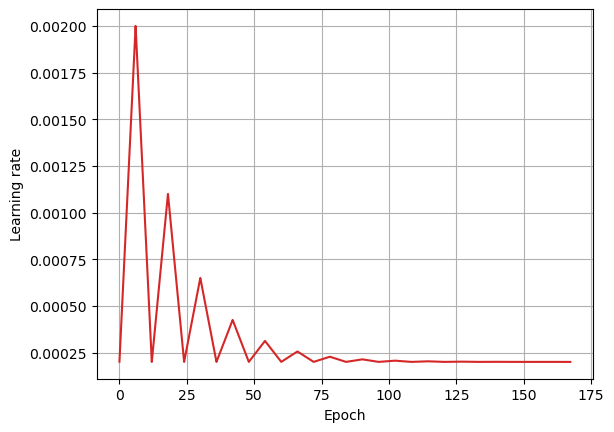

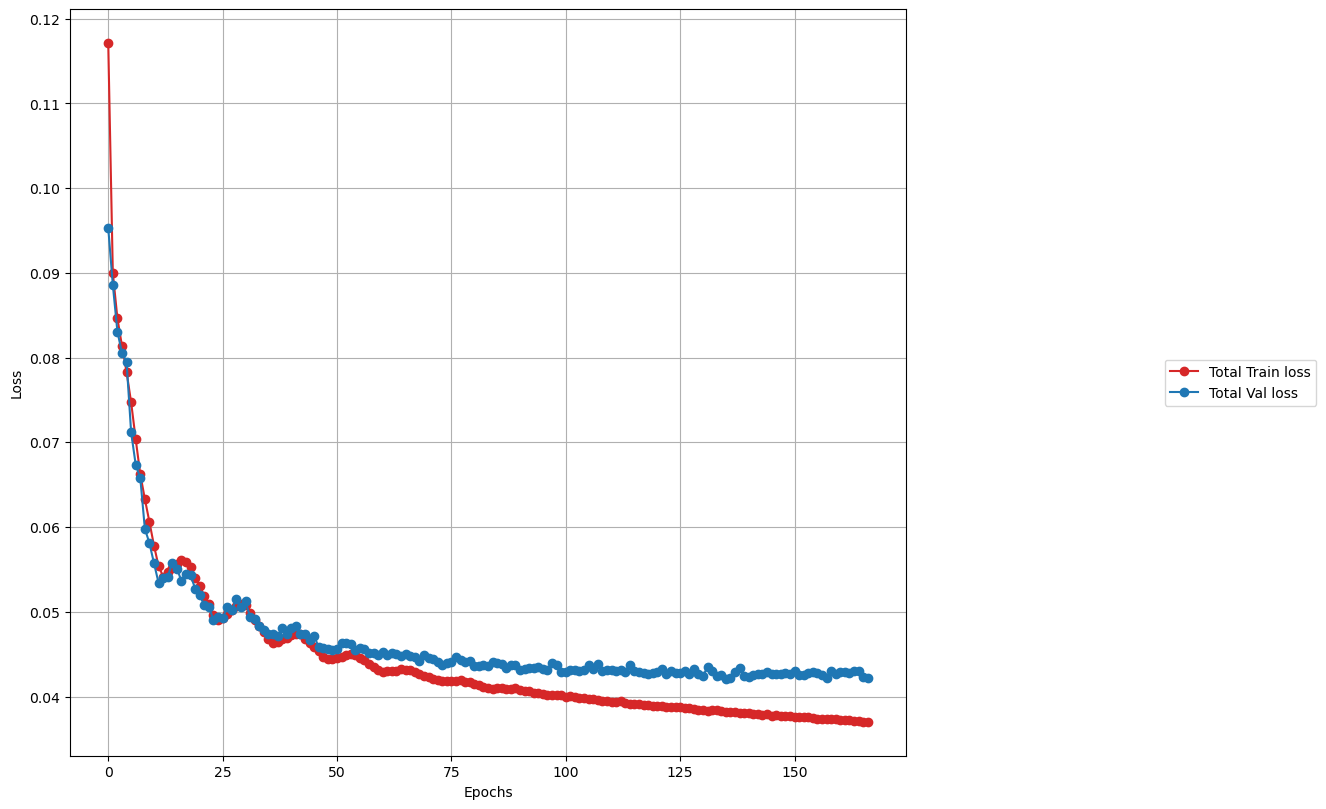

In [13]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

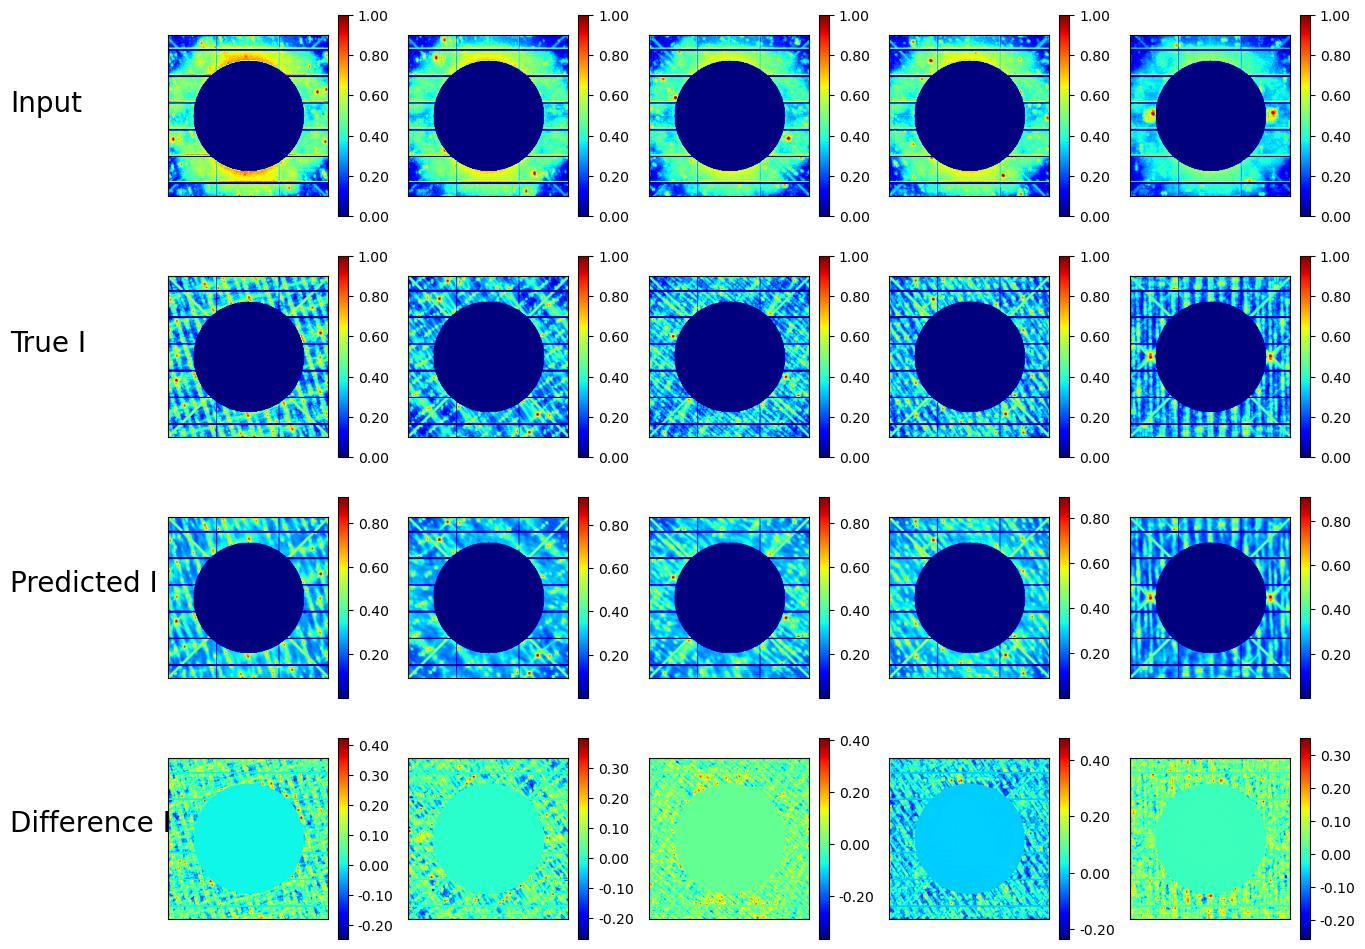

In [14]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

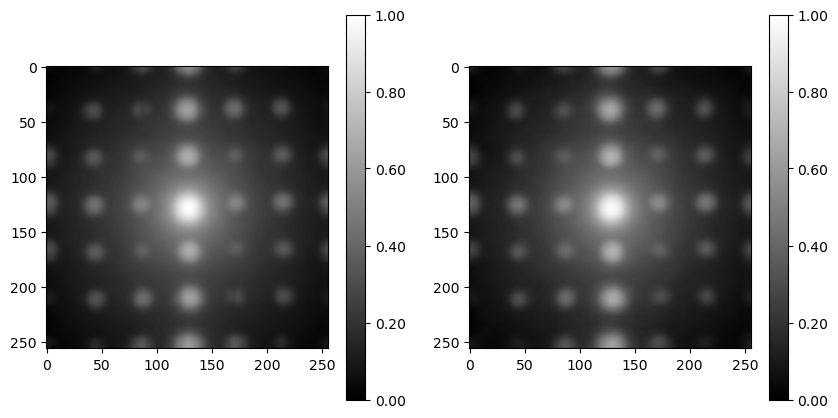

38.36993919777629


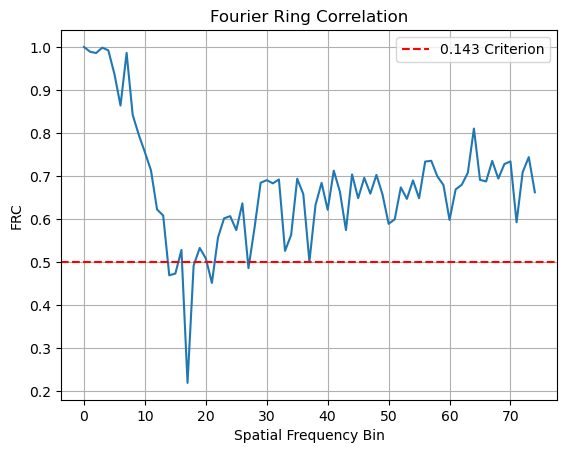

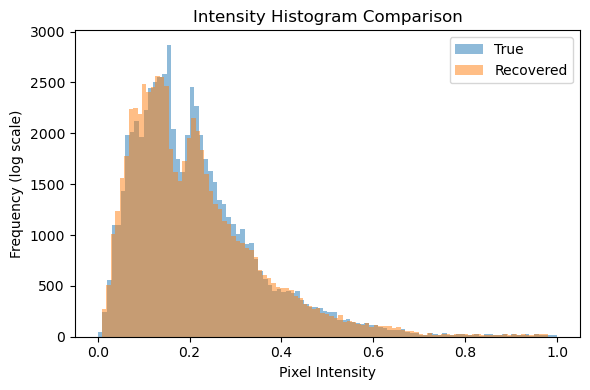

In [15]:
def compute_psnr(img_true, img_recon, max_val=1.0):
    """Compute PSNR between ground truth and reconstructed images."""
    mse = np.mean((img_true - img_recon) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_val ** 2) / mse)
    return psnr

def compute_frc(image1, image2, num_bins=50):
    """Compute the Fourier Ring Correlation between two images."""
    # Compute Fourier transforms
    F1 = fftshift(fft2(image1))
    F2 = fftshift(fft2(image2))

    fig,ax=plt.subplots(1,2,figsize=(10, 5))
    im1=ax[0].imshow(image1, cmap='gray',clim=(0,1))
    im2=ax[1].imshow(image2, cmap='gray',clim=(0,1))
    plt.colorbar(im1, ax=ax[0], format='%.2f')
    plt.colorbar(im2, ax=ax[1], format='%.2f')
    plt.show()
    # Prepare coordinates
    h, w = F1.shape
    y, x = np.indices((h, w))
    center = (h // 2, w // 2)
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    # Bin radial frequencies
    r = r.astype(np.int32)
    max_r = min(center)
    frc = np.zeros(num_bins)
    for i in range(num_bins):
        ring_mask = (r >= i * max_r / num_bins) & (r < (i + 1) * max_r / num_bins)
        F1_ring = F1[ring_mask]
        F2_ring = F2[ring_mask]
        num = np.sum(F1_ring * np.conj(F2_ring))
        denom = np.sqrt(np.sum(np.abs(F1_ring) ** 2) * np.sum(np.abs(F2_ring) ** 2))
        frc[i] = np.abs(num / denom) if denom != 0 else 0
    return frc

def plot_intensity_histograms(img1, img2, labels=('True', 'Recovered'), bins=100):
    plt.figure(figsize=(6,4))
    plt.hist(img1.ravel(), bins=bins, alpha=0.5, label=labels[0])
    plt.hist(img2.ravel(), bins=bins, alpha=0.5, label=labels[1])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency (log scale)')
    plt.title('Intensity Histogram Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
j=int(round(np.random.rand()*ntest))
IMAGE1=Y_I_test[j].reshape(h, w)   
IMAGE2=results[j].reshape(h, w)
frc_curve = compute_frc(IMAGE1, IMAGE2,num_bins=75)
print(compute_psnr(IMAGE1, IMAGE2))
plt.plot(frc_curve)
plt.axhline(0.5, color='r', linestyle='--', label='0.143 Criterion')
plt.xlabel('Spatial Frequency Bin')
plt.ylabel('FRC')
plt.title('Fourier Ring Correlation')
plt.legend()
plt.grid(True)
plt.show()
plot_intensity_histograms(IMAGE1, IMAGE2)